In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
# Importing data
df_test = pd.read_csv('data/test.csv')
df_train = pd.read_csv('data/train.csv')

y = df_train['label']     
X = df_train.drop('label',axis=1)

In [7]:
def scale(data):
    # Scaling the data to be between 0 and 1 since the images we're going to be working with will be grey scale
    scaled_data = data/np.max(data.values)
    return scaled_data

In [8]:
# Scaling data
X = scale(X)
# Reshaping data
X = X.values.reshape(-1,28,28,1)

In [9]:
def plot(data,start=0,save=False):
    """Input: a list of variables containing MNIST data to plot
              what number in the data you want to start at"""
    
    n = 10
    if start == None:
        start=0
    plt.figure(figsize=(20,len(data)*2))
    # Looping over datasets to compare
    for j in range(len(data)):
        # Looping over numbers in each dataset
        for i in range(start,start+n):
             loc = i-start
             ax = plt.subplot(len(data),n,loc+1+(j*n))
             plt.imshow(data[j][i])
             plt.gray()
             ax.get_xaxis().set_visible(False)
             ax.get_yaxis().set_visible(False)

    if save:
        file_name = input("file name:")
        plt.savefig('./results/images/%s_start%s.png'%(file_name,start))

In [17]:
def add_noise(data, noise_level):
    """Adding gaussian noise to the data
        Inputs: list of arrays of data
                noise level of gaussian noise you want added"""
    noise = noise_level*np.random.normal(loc=0,scale=1.0,size=data.shape)
    data = data + noise

    data = np.clip(data,0,1)

    return data,noise

In [18]:
X_noisy, noise = add_noise(X,noise_level=0.5)

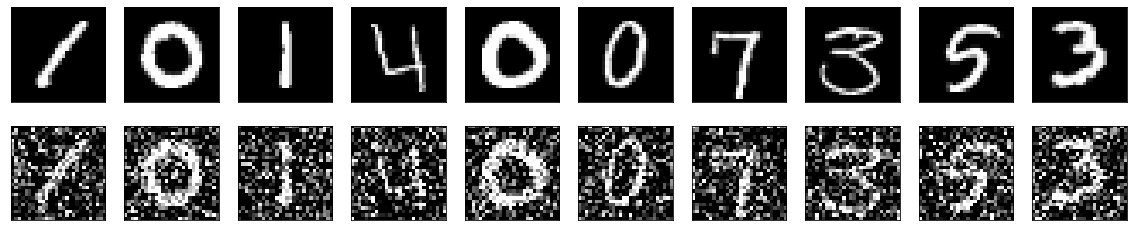

In [19]:
plot([X,X_noisy],0)

In [20]:
def add_model(global_hist,recent_hist,name): 
    """ Input :     Overall history for all models (dataframe)
                    recent model run history (dataframe)
                    name for most recent model (string)
        Output:     Overall history for all models (dataframe) 

    """
    # Removing previous run of this model from model_hist
    global_hist = global_hist[global_hist.model != name]
    recent_hist["model"] = name
    global_hist = pd.concat([global_hist,recent_hist],axis=0)

    return global_hist

In [21]:
# Creating a function to efficiently plot and compare the different models I'm testing
def plot_hist(hist,models,metrics):
    """
    Input: 
        models - list of strings of which models you want to compare, default is all
        metrics - list of strings of which metrics you want to compare"""

    # If empty list passed, all models are compared
    if len(models) == 0: 
        models=list(hist["model"].unique())   
    plt.figure(figsize=(12,6))
    # Looping through all models and metrics and plotting them on the graph with appropriate labels
    for model in models:
        for m in metrics:
            y_plt = hist[(hist["model"]==model)][m].values
            x_plt = range(0,len(y_plt))
            plt.plot(x_plt,y_plt,linewidth=3,label=model+' ('+m+')')
    plt.xlabel('Epochs')
    plt.ylabel(m)
    plt.legend()

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,MaxPool2D,Dropout,UpSampling2D,Input,MaxPooling2D,Conv2DTranspose
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import Model

In [157]:
def AutoEncoderModel():

    """
        blah
    
    """
    input_shape = (28,28,1)
    model = Sequential()
    ##############
    ## Encoding ## 
    ##############
    # First round of downsampling
    model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                    activation ='relu',input_shape=(28,28,1)))
    model.add(MaxPooling2D(pool_size=(2,2),padding='same'))
    # Second round of downsampling
    model.add(Conv2D(filters = 16, kernel_size = (3,3),padding = 'Same', 
                    activation ='relu'))
    model.add(MaxPooling2D(pool_size=(2,2),padding='same'))
    # Third round of downsampling
    model.add(Conv2D(filters = 8, kernel_size = (3,3),padding = 'Same', 
                    activation ='relu'))
    model.add(MaxPooling2D(pool_size=(2,2),padding='same'))
    ##############
    ## Decoding ## 
    ##############
    model.add(Conv2D(filters = 8, kernel_size = (3,3),padding = 'Same', 
                    activation ='relu'))
    model.add(UpSampling2D((2,2)))
    model.add(Conv2D(filters = 16, kernel_size = (3,3),padding = 'Same', 
                    activation ='relu'))
    model.add(UpSampling2D((2,2)))
    model.add(Conv2D(filters = 32, kernel_size = (3,3), 
                    activation ='relu'))
    model.add(UpSampling2D((2,2)))
    model.add(Conv2D(1,(3,3),activation='sigmoid',padding='same'))

    print (model.summary())

    model.compile(optimizer = 'adam' , loss = "binary_crossentropy")
    

    return model


In [158]:
def AutoEncoderModelTr():
    """
        blah
    """
    input_shape = (28,28,1)
    model = Sequential()
    ##############
    ## Encoding ## 
    ##############
    model.add(Conv2D(filters = 32, kernel_size = (3,3), 
                    activation ='relu',input_shape=(28,28,1)))
    model.add(Conv2D(filters = 16, kernel_size = (3,3), 
                    activation ='relu'))
    model.add(Conv2D(filters = 8, kernel_size = (3,3), 
                    activation ='relu'))

    ##############
    ## Decoding ## 
    ##############

    model.add(Conv2DTranspose(filters = 8, kernel_size = (3,3), 
                    activation ='relu'))
    model.add(Conv2DTranspose(filters = 16, kernel_size = (3,3), 
                    activation ='relu'))
    model.add(Conv2DTranspose(filters = 32, kernel_size = (3,3), 
                    activation ='relu'))
    model.add(Conv2D(1,(3,3),activation='sigmoid',padding='same'))

    print(model.summary())

    model.compile(optimizer = 'adam' , loss = "binary_crossentropy")

    
    return model

In [28]:
def AutoEncoderModelUnet(data, start_filters):
    """
        blah
    """
    input_layer = Input(shape=(28,28,1))
    ##############
    ## Encoding ## 
    ##############
                                                                                                        # 28x28x1
    conv1 = Conv2D(start_filters*1, (3, 3), activation="relu", padding="same")(input_layer)             # 28x28x8
    conv1 = Conv2D(start_filters*1, (3, 3), activation="relu", padding="same")(conv1)                   # 28x28x8
    pool1 = MaxPooling2D((2, 2))(conv1)                                                                 # 14x14x8
    pool1 = Dropout(0.25)(pool1)                                                                        # 14x14x8
     
    conv2 = Conv2D(start_filters*2, (3, 3), activation="relu", padding="same")(pool1)                   
    conv2 = Conv2D(start_filters*2, (3, 3), activation="relu", padding="same")(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)                                                                 # 7x7x16
    pool2 = Dropout(0.5)(pool2)

    output_layer = pool2

    ##############
    ## Decoding ## 
    ##############

    # model.add(Conv2DTranspose(filters = 8, kernel_size = (3,3), 
    #                 activation ='relu'))
    # model.add(Conv2DTranspose(filters = 16, kernel_size = (3,3), 
    #                 activation ='relu'))
    # model.add(Conv2DTranspose(filters = 32, kernel_size = (3,3), 
    #                 activation ='relu'))
    # model.add(Conv2D(1,(3,3),activation='sigmoid',padding='same'))

    model = Model(input_layer,output_layer)

    print(model.summary())

    # model.compile(optimizer = 'adam' , loss = "binary_crossentropy")

    
    return model

In [29]:
modelUnet = AutoEncoderModelUnet(X_noisy,start_filters=8)

Model: "functional_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 28, 28, 8)         80        
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 28, 28, 8)         584       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 8)         0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 14, 14, 8)         0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 14, 14, 16)        1168      
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 14, 14, 16)       

In [159]:
from sklearn.model_selection import train_test_split

In [160]:
X_samp = X[0:10000]
X_noisy_samp = X_noisy[0:10000]

In [161]:
X_train_noisy, X_test_noisy ,X_train, X_test = train_test_split(X_noisy_samp,X_samp,test_size=0.2,random_state=101)

In [171]:
callback = EarlyStopping(
    monitor="val_loss",
    min_delta=0.02,
    patience=5,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)

In [172]:
modelTr = AutoEncoderModelTr()

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_120 (Conv2D)          (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_121 (Conv2D)          (None, 24, 24, 16)        4624      
_________________________________________________________________
conv2d_122 (Conv2D)          (None, 22, 22, 8)         1160      
_________________________________________________________________
conv2d_transpose_38 (Conv2DT (None, 24, 24, 8)         584       
_________________________________________________________________
conv2d_transpose_39 (Conv2DT (None, 26, 26, 16)        1168      
_________________________________________________________________
conv2d_transpose_40 (Conv2DT (None, 28, 28, 32)        4640      
_________________________________________________________________
conv2d_123 (Conv2D)          (None, 28, 28, 1)       

In [173]:
modelUpSc = AutoEncoderModel()

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_124 (Conv2D)          (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_125 (Conv2D)          (None, 14, 14, 16)        4624      
_________________________________________________________________
max_pooling2d_34 (MaxPooling (None, 7, 7, 16)          0         
_________________________________________________________________
conv2d_126 (Conv2D)          (None, 7, 7, 8)           1160      
_________________________________________________________________
max_pooling2d_35 (MaxPooling (None, 4, 4, 8)           0         
_________________________________________________________________
conv2d_127 (Conv2D)          (None, 4, 4, 8)         

In [174]:
epochs = 50
batch_size = 128

In [175]:
history = modelUpSc.fit(X_train_noisy, X_train, batch_size = batch_size, epochs = epochs,shuffle=True,
                    validation_data =(X_test_noisy,X_test),callbacks=callback,use_multiprocessing=True)

Epoch 1/50
63/63 [==============================] - 12s 187ms/step - loss: 0.3798 - val_loss: 0.2636
Epoch 2/50
63/63 [==============================] - 12s 193ms/step - loss: 0.2485 - val_loss: 0.2363
Epoch 3/50
63/63 [==============================] - 13s 202ms/step - loss: 0.2213 - val_loss: 0.2090
Epoch 4/50
63/63 [==============================] - 13s 200ms/step - loss: 0.1987 - val_loss: 0.1920
Epoch 5/50
63/63 [==============================] - 12s 190ms/step - loss: 0.1867 - val_loss: 0.1833
Epoch 6/50
63/63 [==============================] - 13s 203ms/step - loss: 0.1789 - val_loss: 0.1764
Epoch 7/50
63/63 [==============================] - 12s 189ms/step - loss: 0.1728 - val_loss: 0.1719
Epoch 8/50
63/63 [==============================] - 12s 188ms/step - loss: 0.1680 - val_loss: 0.1714
Epoch 9/50
63/63 [==============================] - 12s 188ms/step - loss: 0.1642 - val_loss: 0.1635
Epoch 10/50
63/63 [==============================] - 12s 187ms/step - loss: 0.1612 - val_lo

In [176]:
historyTr = modelTr.fit(X_train_noisy, X_train, batch_size = batch_size, epochs = epochs,shuffle=True,
                    validation_data =(X_test_noisy,X_test),callbacks=callback,use_multiprocessing=True)

Epoch 1/50
63/63 [==============================] - 19s 304ms/step - loss: 0.4081 - val_loss: 0.1812
Epoch 2/50
63/63 [==============================] - 19s 304ms/step - loss: 0.1389 - val_loss: 0.1232
Epoch 3/50
63/63 [==============================] - 20s 319ms/step - loss: 0.1189 - val_loss: 0.1155
Epoch 4/50
63/63 [==============================] - 20s 314ms/step - loss: 0.1127 - val_loss: 0.1119
Epoch 5/50
63/63 [==============================] - 20s 311ms/step - loss: 0.1102 - val_loss: 0.1107
Epoch 6/50
63/63 [==============================] - 19s 302ms/step - loss: 0.1086 - val_loss: 0.1084
Epoch 7/50
63/63 [==============================] - 21s 329ms/step - loss: 0.1076 - val_loss: 0.1073


In [177]:
decoded_img = modelUpSc.predict(X_test)

In [178]:
decoded_imgTr = modelTr.predict(X_test)

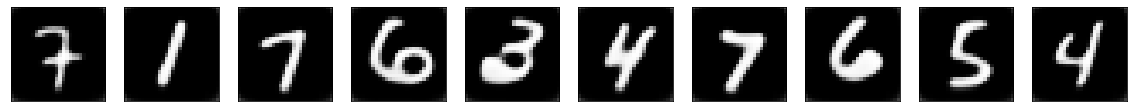

In [195]:
plot([decoded_imgTr],save=True)

In [190]:
historyTr = pd.DataFrame(historyTr.history)
historyTr["model"] = 'Tr0.6'
hist = pd.DataFrame(history.history)
hist["model"]='UpSc0.6'

AttributeError: 'DataFrame' object has no attribute 'history'

In [191]:
model_hist = add_model(hist,historyTr,name='Tr0.6')

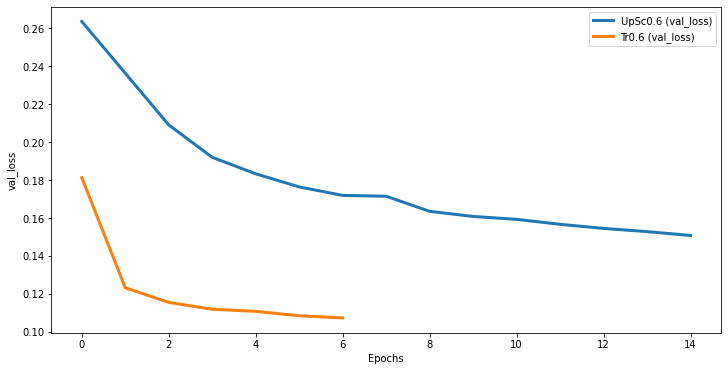

In [192]:
plot_hist(model_hist,models=['UpSc0.6','Tr0.6'],metrics=['val_loss'])

In [183]:
from tensorflow.keras.utils import plot_model

In [184]:
#img_file = './tmp/model_UpSc.png'
#img_file2 = './tmp/model_Tr.png'

In [185]:
#plot_model(model, to_file=img_file,show_shapes=True)
#plot_model(modelTr, to_file=img_file2,show_shapes=True)

In [197]:
modelUpSc.save('./models/model_UpSc0.6')
modelTr.save('./models/model_Tr0.6')

INFO:tensorflow:Assets written to: ./models/model_UpSc0.6/assets
INFO:tensorflow:Assets written to: ./models/model_UpSc0.6/assets
INFO:tensorflow:Assets written to: ./models/model_Tr0.6/assets
INFO:tensorflow:Assets written to: ./models/model_Tr0.6/assets


In [198]:
from tensorflow.keras.models import load_model

In [205]:
modelUpSc02 = load_model('./models/model_UpSc')
modelUpSc06 = load_model('./models/model_UpSc0.6')
modelTr02 = load_model('./models/model_Tr')
modelTr06 = load_model('./models/model_Tr0.6')

In [206]:
X_noisy02, noise = add_noise(X,noise_level=0.2)
X_noisy06, noise = add_noise(X,noise_level=0.6)

In [218]:
denoise06_w_m02 = modelTr02.predict(X_noisy06[0:10])
denoise02_w_m06 = modelTr06.predict(X_noisy02[0:10])
denoise02_w_m02 = modelTr02.predict(X_noisy02[0:10])
denoise06_w_m06 = modelTr02.predict(X_noisy02[0:10])

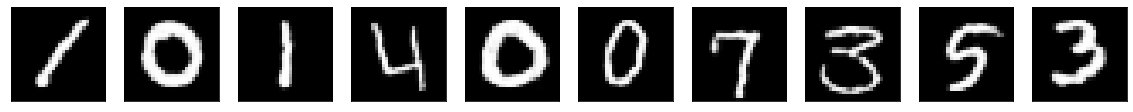

In [219]:
plot([denoise06_w_m06],save=True)

In [224]:
diff_n06_m06 = X[0:10]-denoise06_w_m06

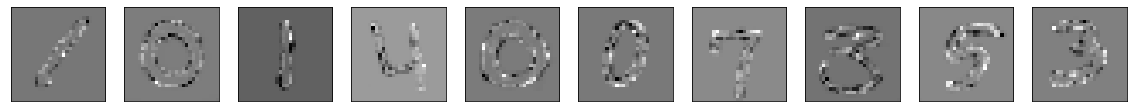

In [225]:
plot([diff_n06_m06])